Analyses properties of decorrelation and whitening methods for FC and Convolutional cases.

In [1]:
import numpy as np
import torch
from decorrelation.decorrelation import lower_triangular, Decorrelation, DecorConv2d # DecorrelationPatch2d # covariance, DecorrelationPatch2d, DecorrelationFC, lower_triangular
from decorrelation.plotting import *
from decorrelation.utils import generate_correlated_data

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def train(num_epochs, data, model):

    # covariance matrix before training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A1 = (X.T @ X) / len(X)

    # train decorrelator
    L = np.zeros(num_epochs)
    for i in range(num_epochs):
        model.forward(data)
        L[i] = model.update()

    # covariance matrix after training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A2 = (X.T @ X) / len(X)

    return L, A1, A2

We start by showing effective decorrelation of correlated input

mean variance: 1.00


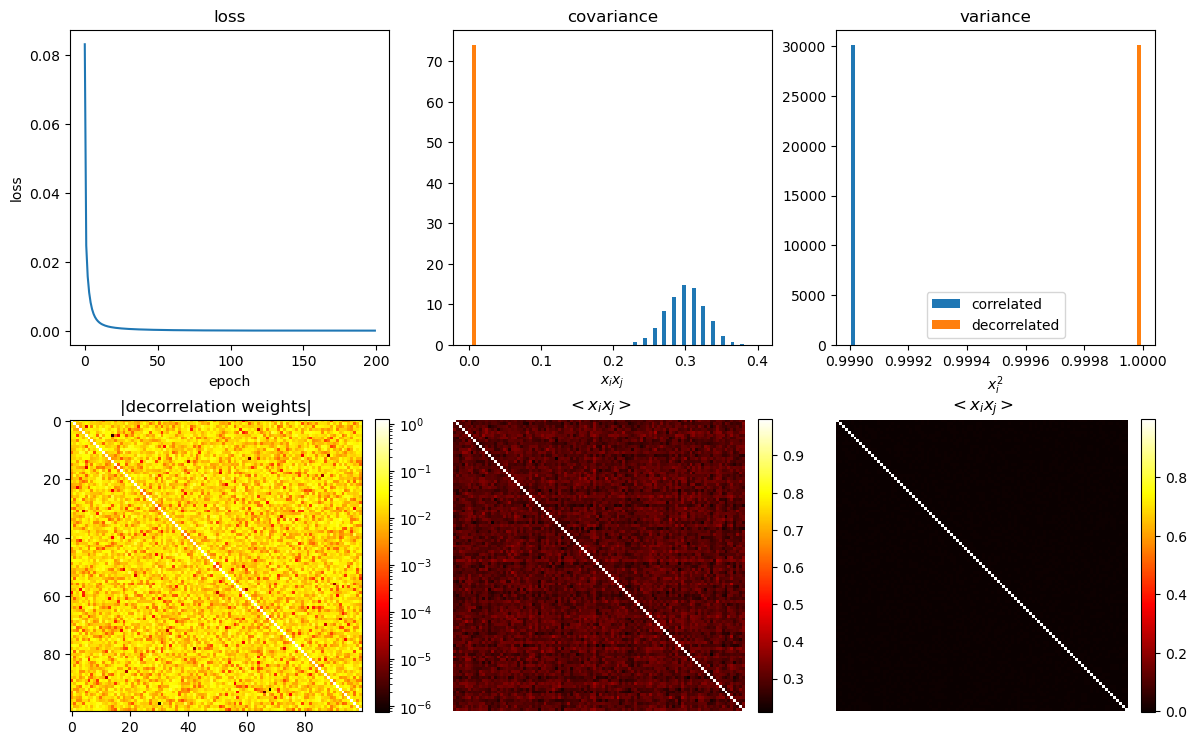

In [25]:
num_samples=1000
num_features=100
num_epochs=200
seed=42
decor_lr=1e-0
bias_lr=0.0
kappa=1e-1

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# generate correlated data
data = generate_correlated_data(num_features, num_samples).to(device)

# create a decorrelator
model = Decorrelation(in_features=num_features, decor_lr=decor_lr, bias_lr=bias_lr, kappa=kappa).to(device)

L, A1, A2 = train(num_epochs, data, model)

plot_decorrelation_results(model, L, A1, A2)
print(f'mean variance: {torch.mean(torch.diag(A2)):.2f}')


Show the same for learning a lower triangular matrix

mean variance: 0.83


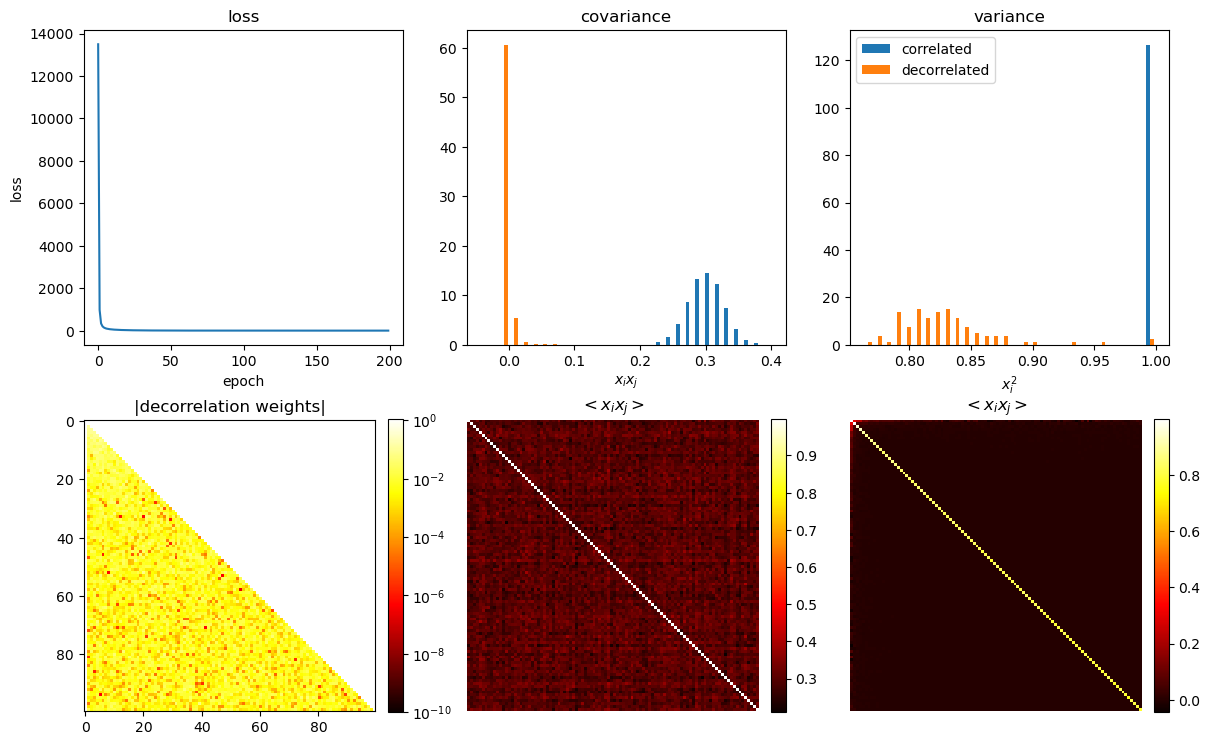

In [4]:
num_samples=1000
num_features=100
num_epochs=200
seed=42
decor_lr=1e-2
kappa=1e-1

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# generate correlated data
data = generate_correlated_data(num_features, num_samples).to(device)

# create a decorrelator
model = Decorrelation(in_features=num_features, decor_lr=1e-2, bias_lr=bias_lr, kappa=kappa, full=False).to(device)

L, A1, A2 = train(num_epochs, data, model)

plot_decorrelation_results(model, L, A1, A2)
print(f'mean variance: {torch.mean(torch.diag(A2)):.2f}')


Show the impact of debiasing of the data (will have positive effect if weights start to grow during optimization; may allow even higher stable decorrelation learning rates)

mean variance: 1.00


tensor([-0.3260, -0.3565, -0.3209, -0.2959, -0.2416, -0.2348, -0.2982, -0.3301,
        -0.3305, -0.3071, -0.2975, -0.2560, -0.3637, -0.2956, -0.3298, -0.3142,
        -0.2479, -0.3106, -0.2745, -0.2953, -0.2703, -0.2246, -0.3098, -0.2789,
        -0.3564, -0.3046, -0.1943, -0.3320, -0.2954, -0.3860, -0.2946, -0.2758,
        -0.2660, -0.2979, -0.2784, -0.3567, -0.2522, -0.3675, -0.2961, -0.3025,
        -0.3428, -0.2857, -0.3166, -0.2569, -0.3022, -0.2460, -0.3210, -0.3070,
        -0.1888, -0.3714, -0.3358, -0.2827, -0.3166, -0.2847, -0.2704, -0.3095,
        -0.2607, -0.3255, -0.2961, -0.3422, -0.3691, -0.3420, -0.2624, -0.3246,
        -0.3042, -0.2922, -0.2802, -0.2245, -0.2906, -0.2779, -0.2762, -0.2678,
        -0.2667, -0.3655, -0.2627, -0.3040, -0.2357, -0.3711, -0.2323, -0.2885,
        -0.3533, -0.2480, -0.2974, -0.3327, -0.2687, -0.3071, -0.2752, -0.2826,
        -0.3910, -0.3040, -0.2196, -0.2604, -0.3516, -0.3827, -0.3022, -0.2442,
        -0.3708, -0.3086, -0.3194, -0.26

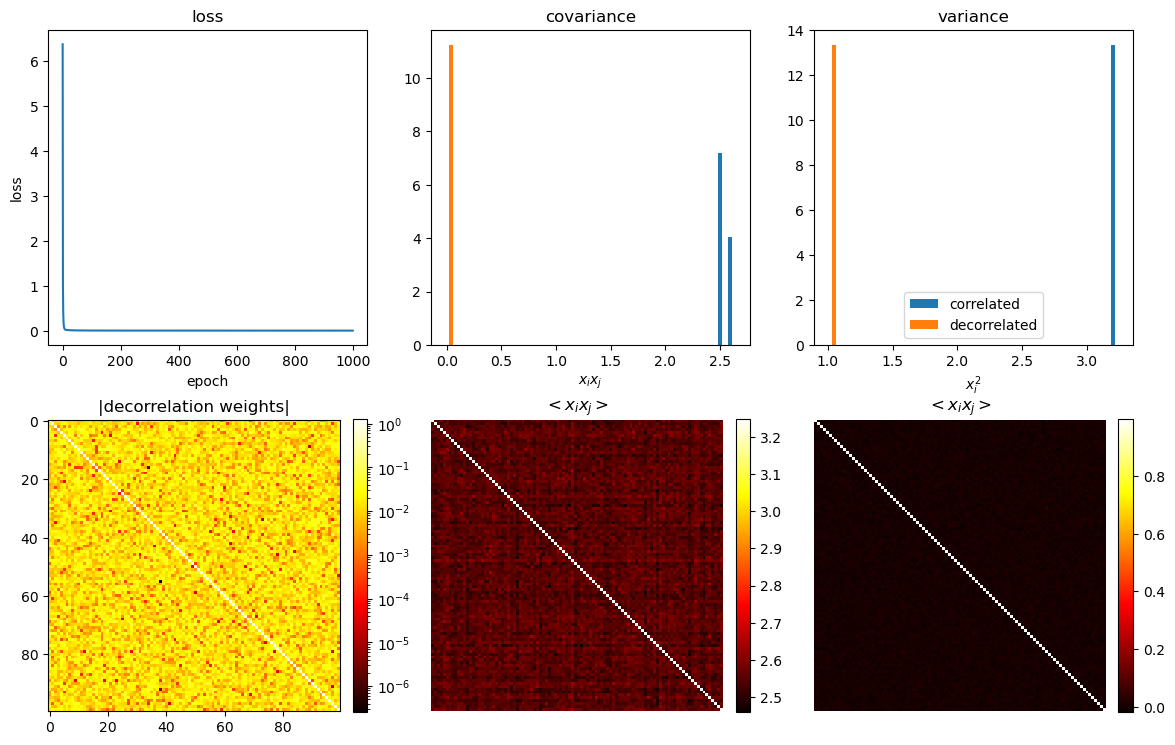

In [5]:
num_samples=1000
num_features=100
num_epochs=1000
seed=42
decor_lr=1e-1
bias_lr=1e-1
kappa=1e-1

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# generate correlated data
data = generate_correlated_data(num_features, num_samples).to(device) + 1.5

# create a decorrelator
model = Decorrelation(in_features=num_features, decor_lr=decor_lr, bias_lr=bias_lr, kappa=kappa).to(device)

L, A1, A2 = train(num_epochs, data, model)

plot_decorrelation_results(model, L, A1, A2)
print(f'mean variance: {torch.mean(torch.diag(A2)):.2f}')
model.bias

Shows how offsets lead to huge gradients

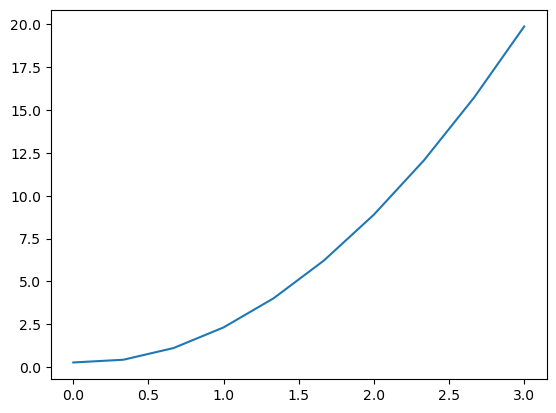

In [6]:
import copy

num_samples=1000
num_features=100
num_epochs=1000
seed=42
decor_lr=1
bias_lr=1e-1
kappa=1e-1

offsets = np.linspace(0, 3, 10)

grads = torch.zeros(len(offsets))
for i, offset in enumerate(offsets):

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

    # generate correlated data
    data = generate_correlated_data(num_features, num_samples).to(device) + offset

    # create a decorrelator
    model = Decorrelation(in_features=num_features, decor_lr=decor_lr, bias_lr=bias_lr, kappa=kappa).to(device)

    w_old = copy.deepcopy(model.weight.data)
    model.forward(data)
    model.update()
    grads[i] = torch.norm(model.weight-w_old)

plt.plot(offsets, grads);

Decorrelation of a convolutional input

mean variance: 1.01


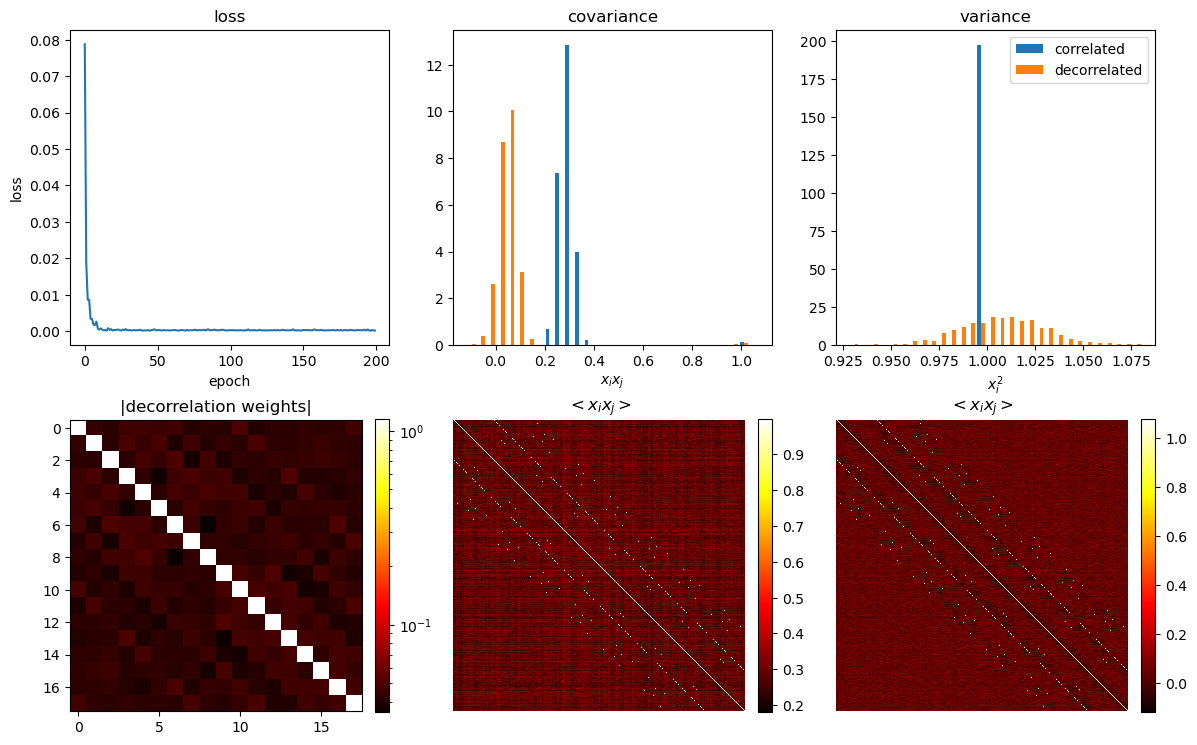

In [13]:
# generate [N, M] correlated input
in_channels=2
out_channels=3
height=10
width=10
kernel_size=(3,3)
num_samples=1000
num_epochs=200
seed=42
decor_lr=1e-0
kappa=1e-1
downsample_perc=0.1

num_features=in_channels*height*width
size = in_channels * np.prod(kernel_size)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

data = generate_correlated_data(num_features, num_samples).reshape(num_samples,in_channels,height,width).to(device)

# d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.1 * torch.eye(num_features) + 0.9 * torch.ones((num_features, num_features)))
# data = d.sample((num_examples,)).reshape(num_examples,in_channels,height,width).to(device)

# create a convolutional decorrelator
# NOTE: how many samples for effective input decorrelation? Dependence on dim?
# nr of samples instead of perc?
# NOTE: version for immediate non-batched decorrelation...
model = DecorConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, decor_lr=decor_lr, bias_lr=bias_lr, kappa=kappa, downsample_perc=downsample_perc).to(device)

L, A1, A2 = train(num_epochs, data, model)

plot_decorrelation_results(model, L, A1, A2)
print(f'mean variance: {torch.mean(torch.diag(A2)):.2f}')


Test the effect of downsampling

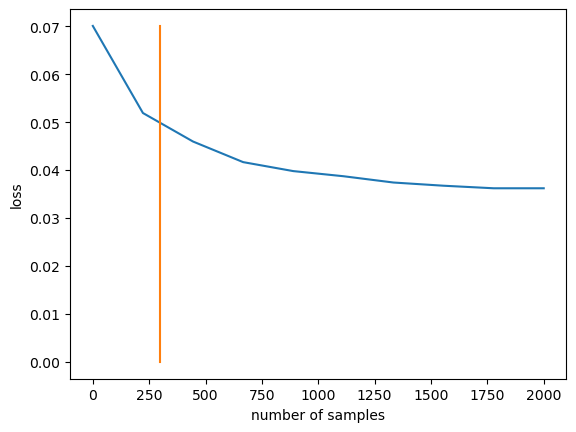

In [58]:
def compute_decor_sample_size(decor_lr, num_samples, num_features):
    
    num_epochs=50
    seed=42
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

    # generate correlated data
    data = generate_correlated_data(num_features, num_samples).to(device)

    percs = torch.linspace(0.1,1,10)
    L = torch.zeros(len(percs))
    for i, p in enumerate(percs):

        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        np.random.seed(seed)

        model = Decorrelation(in_features=num_features, decor_lr=decor_lr, bias_lr=0.0, kappa=0.5).to(device)

        num_samples = int(len(data) * p)
        idx = np.random.choice(np.arange(len(data)), size=num_samples)

        loss = 0
        for j in range(num_epochs):
            model.forward(data[idx])
            loss = model.update()
        
        L[i] = loss

    return L, percs

decor_lr=1e0
num_samples=2000
num_features=300
L, percs = compute_decor_sample_size(decor_lr, num_samples, num_features)

plt.plot(percs*num_samples, L)
plt.plot([num_features, num_features],[0, max(L)])
plt.xlabel('number of samples')
plt.ylabel('loss');

Test impact of decorrelation strength

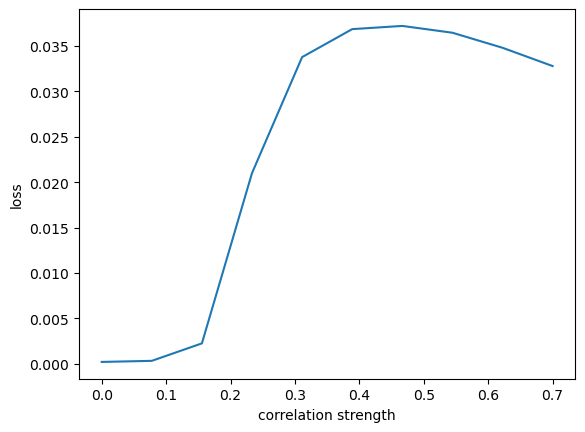

In [65]:
def compute_decor_strength(decor_lr, num_samples, num_features):
    
    num_epochs=50
    seed=42
    
    percs = torch.linspace(0,0.7,10)
    L = torch.zeros(len(percs))
    for i, p in enumerate(percs):

        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        np.random.seed(seed)

        # generate correlated data
        data = generate_correlated_data(num_features, num_samples, strength=p).to(device)

        model = Decorrelation(in_features=num_features, decor_lr=decor_lr, bias_lr=0.0, kappa=0.5).to(device)

        loss = 0
        for j in range(num_epochs):
            model.forward(data)
            loss = model.update()
        
        L[i] = loss

    return L, percs

decor_lr=1e0
num_samples=2000
num_features=300
L, percs = compute_decor_strength(decor_lr, num_samples, num_features)

plt.plot(percs, L)
plt.xlabel('correlation strength')
plt.ylabel('loss');